In [126]:
%matplotlib inline
import matplotlib.pyplot as plt

import scipy.stats as stats
import numpy as np
import jsonlines
from pathlib import Path
from hydra import initialize, compose
import torchvision

import dr_util.file_utils as fu
import dr_gen.utils.model as mu
import dr_gen.utils.run as ru

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Setup Config and Generator

In [2]:
with initialize(config_path="../configs/", version_base=None):
    cfg = compose(
        config_name="config.yaml",
    )

In [3]:
generator = ru.set_deterministic(cfg.seed)

### Utils

In [14]:
def get_all_logs(base_dir):
    log_dir = Path(base_dir)
    all_files = [f for f in log_dir.rglob("*.jsonl") if f.is_file()]
    all_file_data = {str(f): fu.load_file(str(f)) for f in all_files}
    return all_file_data

In [18]:
def parse_run_log(log_data):
    run_cfg = log_data[0].get("value", {})
    metrics = {k: [] for k in ['train', 'val', 'eval']}
    for l in log_data[1:]:
        data_name = l.get("data_name", None)
        if data_name in metrics:
            metrics[data_name].append(l)
    return run_cfg, metrics

In [49]:
def plot_parsed_metrics(tm, lr="", wd="", initialization=""):
    # Extract acc1 values from each entry in data['train']
    acc1_values = [entry['agg_stats']['acc1'] for entry in tm['train']]
    acc1_val = [entry['agg_stats']['acc1'] for entry in tm['val']]
    acc1_eval = [entry['agg_stats']['acc1'] for entry in tm['eval']]
    
    # Create an index for each data point (0, 1, 2, ...)
    indices = list(range(len(acc1_values)))
    
    # Plotting
    plt.figure(figsize=(10, 6))
    #plt.plot(indices, acc1_values, marker='o', linestyle='-', color='b')
    plt.plot(indices, acc1_values, linestyle='-', label="train")
    plt.plot(indices, acc1_val, linestyle='-', label="val")
    plt.plot(indices, acc1_eval, linestyle='-', label="eval")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title(f"Accuracy During Training, lr{lr}, wd{wd}, {initialization}")
    plt.grid(True)
    plt.legend()
    plt.show()

In [52]:
def plot_parsed(conf, metrics):
    plot_parsed_metrics(
        metrics,
        lr=conf['optim']['lr'],
        wd=conf['optim']['weight_decay'],
        initialization="Random Init" if conf['model']['weights'] is None else conf['model']['weights'],
    )
    

In [56]:
def parse_run_logs(all_file_data):
    parsed_runs = []
    for k, v in all_file_data.items():
        try:
            parsed_runs.append([k, *parse_run_log(v)])
        except:
            pass
    return parsed_runs

In [66]:
def filter_parsed_runs(prs, lr=None, wd=None, init=None):
    subset = []
    for k, cf, ms in prs:
        if cf['optim']['lr'] == '':
            continue
        if lr is not None and float(cf['optim']['lr']) != lr:
            continue
        if wd is not None and float(cf['optim']['weight_decay']) != wd:
            continue
            
        if init == "random" and cf['model']['weights'] is not None:
            continue
        elif init == "pretrained" and cf['model']['weights'] != "DEFAULT":
            continue
        subset.append((k, cf, ms))
    return subset

In [86]:
def plot_acc1_histogram(runs, index, split_name, hist_range, nbins):
    """
    Plots a histogram of the 'acc1' metric from a given split at a specified index across runs.
    
    Parameters:
        runs (list): List of runs, where each run is a tuple of 
                     (run_name, run_config, run_metrics).
                     run_metrics should be a dict with keys 'train', 'val', 'eval',
                     each mapping to a list of metric dictionaries.
        index (int): The index into the list of metrics for the split.
        split_name (str): One of 'train', 'val', or 'eval'.
    """
    acc1_values = []
    
    for run in runs:
        # Unpack each run; you might not need run_name and run_config for this function.
        run_name, run_config, run_metrics = run
        
        # Check if the desired split exists and the index is within range.
        if split_name in run_metrics and len(run_metrics[split_name]) > index:
            metric = run_metrics[split_name][index]
            # Extract the acc1 value from the metric's 'agg_stats'
            acc1 = metric.get('agg_stats', {}).get('acc1')
            if acc1 is not None:
                acc1_values.append(acc1)
    
    if not acc1_values:
        print(f"No valid acc1 values found for split '{split_name}' at index {index}.")
        return

    # Plot the histogram using matplotlib
    plt.figure(figsize=(10, 6))
    plt.hist(acc1_values, bins=nbins, edgecolor='black', range=hist_range)
    plt.xlabel("acc1")
    plt.ylabel("Frequency")
    plt.title(f"Histogram of acc1 values (split='{split_name}', index={index})")
    plt.grid(True)
    plt.show()

In [89]:
def plot_acc1_histograms(runs, index, splits=["train", "val", "eval"], hist_range=None, nbins=10):
    """
    Plots overlaid histograms of the 'acc1' metric for multiple splits at a given index across runs.

    Parameters:
        runs (list): List of runs, where each run is a tuple of 
                     (run_name, run_config, run_metrics).
                     run_metrics should be a dict with keys (e.g. 'train', 'val', 'eval'),
                     each mapping to a list of metric dictionaries.
        index (int): The index into the list of metrics for each split.
        splits (list): List of split names to plot (default is ["train", "val", "eval"]).
        hist_min (float, optional): Minimum value for the histogram bins.
        hist_max (float, optional): Maximum value for the histogram bins.
    """
    # Dictionary to store acc1 values for each split.
    split_values = {split: [] for split in splits}
    
    for run in runs:
        run_name, run_config, run_metrics = run
        for split in splits:
            if split in run_metrics and len(run_metrics[split]) > index:
                metric = run_metrics[split][index]
                acc1 = metric.get('agg_stats', {}).get('acc1')
                if acc1 is not None:
                    split_values[split].append(acc1)
    
    # Check that we got some data.
    if all(len(vals) == 0 for vals in split_values.values()):
        print("No valid acc1 values found for any specified split at the given index.")
        return

    # Set up a color map for splits.
    default_colors = {"train": "blue", "val": "green", "eval": "red"}
    colors = {split: default_colors.get(split, None) for split in splits}
    
    # Determine histogram range if bounds are provided.
    #hist_range = (hist_min, hist_max) if (hist_min is not None and hist_max is not None) else None
    
    plt.figure(figsize=(10, 6))
    
    # Plot histogram for each split using histtype 'step' for overlay.
    for split in splits:
        values = split_values[split]
        if values:
            plt.hist(
                values,
                bins=nbins,
                edgecolor=colors[split],
                range=hist_range,
                histtype='step',
                label=split,
            )
    
    plt.xlabel("acc1")
    plt.ylabel("Frequency")
    plt.title(f"Histogram of acc1 values at index {index} for splits {', '.join(splits)}")
    plt.legend()
    plt.grid(True)
    plt.show()

In [101]:
def plot_split_histogram_two_run_sets(run_set1, run_set2, index, split_name, hist_range=None, nbins=10, names=['Set 1', 'Set 2']):
    """
    Plots overlaid histograms of the 'acc1' metric at a given index for a specified split,
    comparing two different run sets on the same plot.
    
    Parameters:
        run_set1 (list): A list of runs. Each run is a tuple 
                         (run_name, run_config, run_metrics), where run_metrics is a dict
                         mapping split names (e.g. 'train') to a list of metric dicts.
        run_set2 (list): Another list of runs with the same structure.
        index (int): The index into the list of metrics for the given split.
        split_name (str): The split to extract from ('train', 'val', or 'eval').
        hist_min (float, optional): Minimum value for the histogram bins.
        hist_max (float, optional): Maximum value for the histogram bins.
    """
    # Extract acc1 values for run_set1
    values1 = []
    for run in run_set1:
        run_name, run_config, run_metrics = run
        if split_name in run_metrics and len(run_metrics[split_name]) > index:
            metric = run_metrics[split_name][index]
            acc1 = metric.get('agg_stats', {}).get('acc1')
            if acc1 is not None:
                values1.append(acc1)
                
    # Extract acc1 values for run_set2
    values2 = []
    for run in run_set2:
        run_name, run_config, run_metrics = run
        if split_name in run_metrics and len(run_metrics[split_name]) > index:
            metric = run_metrics[split_name][index]
            acc1 = metric.get('agg_stats', {}).get('acc1')
            if acc1 is not None:
                values2.append(acc1)
                
    # Check if there is data to plot
    if not values1 and not values2:
        print(f"No valid 'acc1' values found for split '{split_name}' at index {index} in both run sets.")
        return
    if not values1:
        print(f"No valid 'acc1' values found for split '{split_name}' at index {index} in run set 1.")
    if not values2:
        print(f"No valid 'acc1' values found for split '{split_name}' at index {index} in run set 2.")
    
    # Define the histogram range if bounds are provided
    #hist_range = (hist_min, hist_max) if (hist_min is not None and hist_max is not None) else None

    plt.figure(figsize=(10, 6))
    
    # Plot histogram for run set 1 in blue
    if values1:
        plt.hist(values1, bins=nbins, histtype='step', edgecolor='blue', range=hist_range, label=names[0])
        mean1 = sum(values1) / len(values1)
        plt.axvline(mean1, color='blue', linestyle='dashed', linewidth=1.5, label=f'{names[0]} Mean: ({mean1:.2f})')
        
    # Plot histogram for run set 2 in red
    if values2:
        plt.hist(values2, bins=nbins, histtype='step', edgecolor='red', range=hist_range, label=names[1])
        mean2 = sum(values2) / len(values2)
        plt.axvline(mean2, color='red', linestyle='dashed', linewidth=1.5, label=f'{names[1]} Mean: ({mean2:.2f})')
        
    plt.xlabel("acc1")
    plt.ylabel("Frequency")
    plt.title(f"Histogram of acc1 values for split '{split_name}' at index {index}")
    plt.legend()
    plt.grid(True)
    plt.show()


### Find Relevant Logs

In [15]:
run_logs = get_all_logs("/scratch/ddr8143/logs")

In [57]:
parsed_runs = parse_run_logs(run_logs)

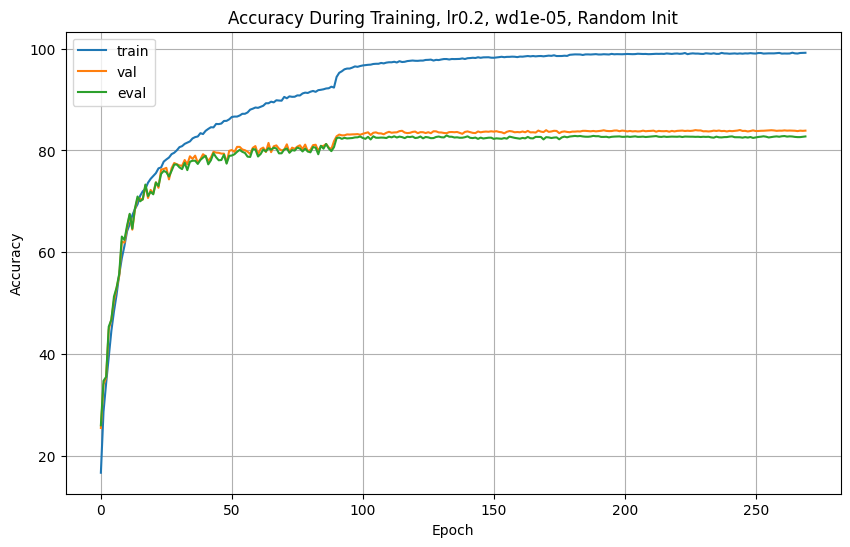

In [71]:
plot_parsed(parsed_runs[0][1], parsed_runs[0][2])

In [72]:
default_hpm_random_runs = filter_parsed_runs(parsed_runs, lr=0.1, wd=1e-4, init="random")

In [73]:
len(default_hpm_random_runs)

21

In [79]:
higher_lr_random_runs = filter_parsed_runs(parsed_runs, lr=0.2, wd=1e-4, init="random")

In [80]:
len(higher_lr_random_runs)

20

### Plot Comparitive Histograms

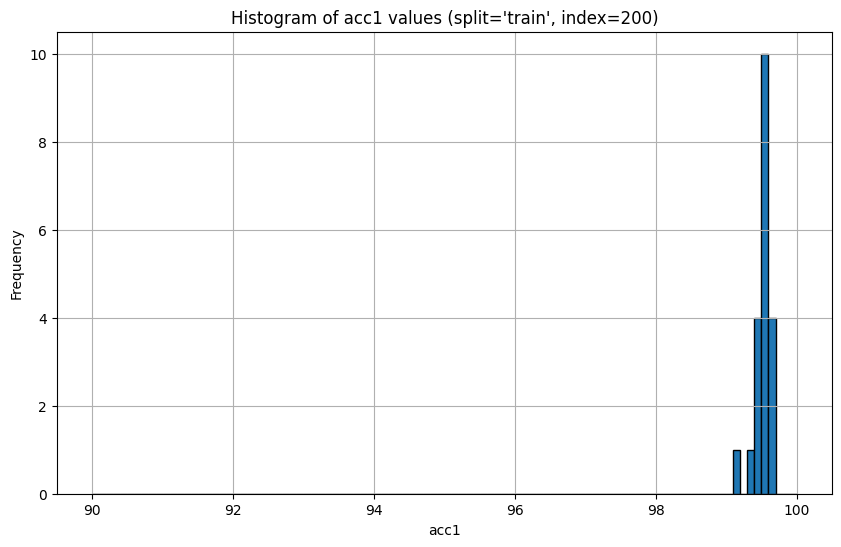

In [87]:
plot_acc1_histogram(default_hpm_random_runs, 200, "train", (90.0, 100.0), 100)

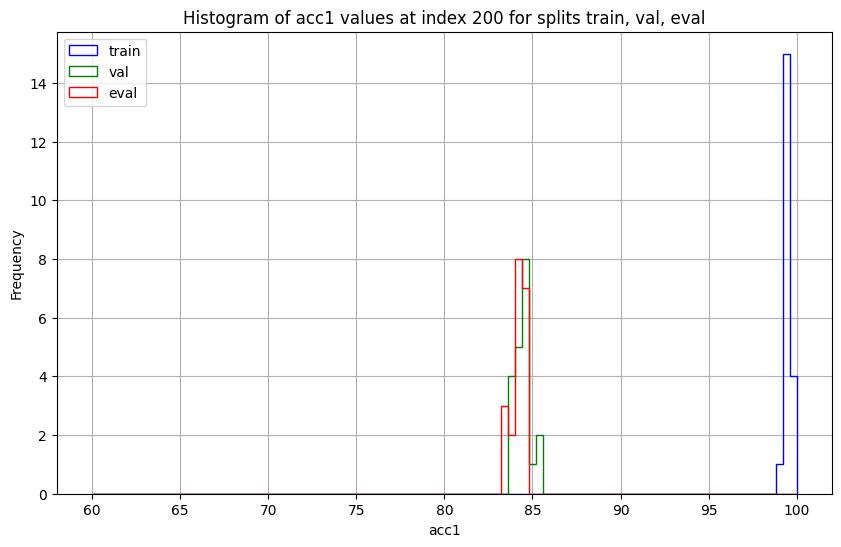

In [92]:
plot_acc1_histograms(default_hpm_random_runs, 200, ["train", "val", "eval"], (60.0, 100.0), 100)

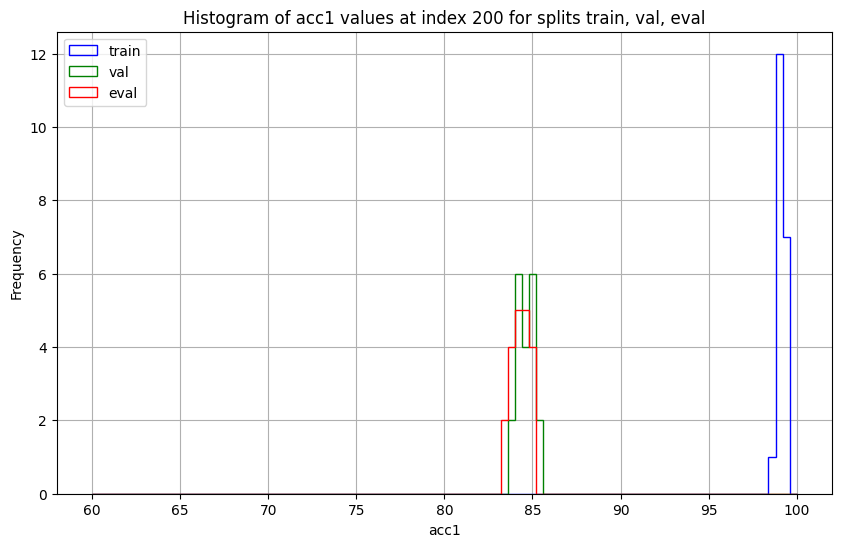

In [93]:
plot_acc1_histograms(higher_lr_random_runs, 200, ["train", "val", "eval"], (60.0, 100.0), 100)

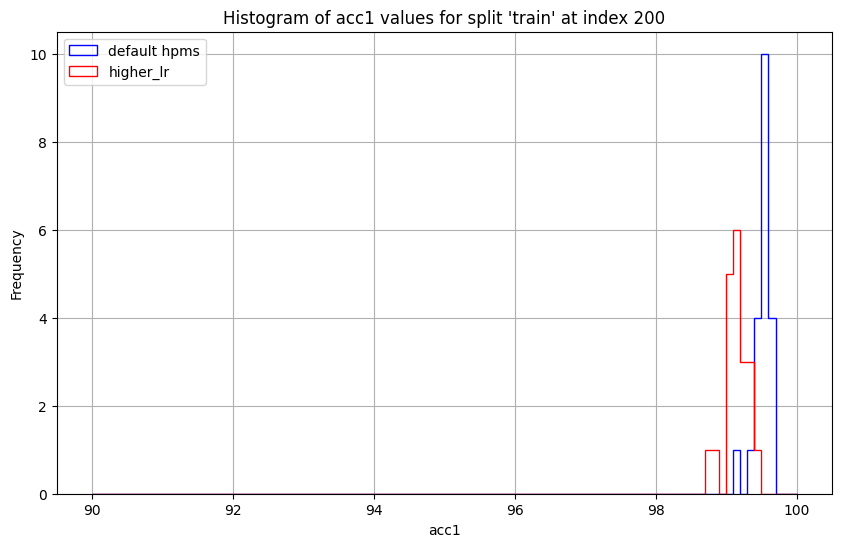

In [98]:
plot_split_histogram_two_run_sets(default_hpm_random_runs, higher_lr_random_runs, index=200, split_name="train", hist_range=(90,100), nbins=100, names=['default hpms', 'higher_lr'])

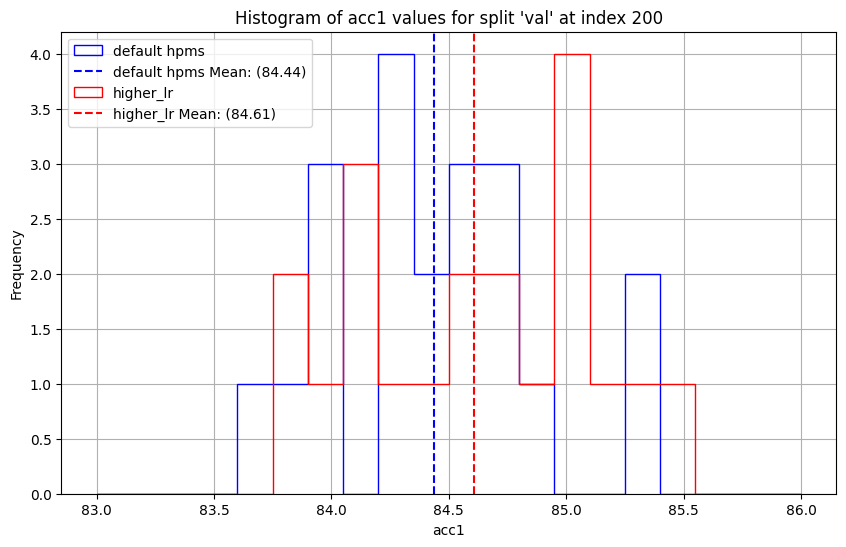

In [104]:
plot_split_histogram_two_run_sets(default_hpm_random_runs, higher_lr_random_runs, index=200, split_name="val", hist_range=(83,86), nbins=20, names=['default hpms', 'higher_lr'])

### KS Statistics

In [124]:
def find_max_diff_point(values1, values2):
    """
    Given two lists of numeric values, compute their empirical CDFs
    and return the value at which the absolute difference between
    the two CDFs is maximized. Also return the KS statistic and the
    corresponding CDF values for each group.
    
    Parameters:
        values1 (list or np.ndarray): The first set of numeric values.
        values2 (list or np.ndarray): The second set of numeric values.
        
    Returns:
        max_diff_value (float): The x-value at which the maximum difference occurs.
        ks_stat (float): The maximum absolute difference (KS statistic).
        cdf1 (float): The empirical CDF of values1 at max_diff_value.
        cdf2 (float): The empirical CDF of values2 at max_diff_value.
    """
    v1 = np.sort(np.array(values1))
    v2 = np.sort(np.array(values2))
    
    # Combine both arrays and get unique sorted values.
    all_vals = np.sort(np.unique(np.concatenate([v1, v2])))
    
    # For each unique value, compute the proportion of values in each sample that are <= that value.
    cdf1 = np.searchsorted(v1, all_vals, side='right') / len(v1)
    cdf2 = np.searchsorted(v2, all_vals, side='right') / len(v2)
    
    # Compute absolute differences between the two CDFs.
    differences = np.abs(cdf1 - cdf2)
    max_idx = np.argmax(differences)
    max_diff_value = all_vals[max_idx]
    ks_stat = differences[max_idx]
    
    return max_diff_value, ks_stat, cdf1[max_idx], cdf2[max_idx]

In [119]:
def extract_values(run_set1, run_set2, index, split_name):
    # Extract acc1 values for the first run set.
    acc1_vals1 = []
    for run in run_set1:
        run_name, run_config, run_metrics = run
        if split_name in run_metrics and len(run_metrics[split_name]) > index:
            metric = run_metrics[split_name][index]
            acc1 = metric.get('agg_stats', {}).get('acc1')
            if acc1 is not None:
                acc1_vals1.append(acc1)
    
    # Extract acc1 values for the second run set.
    acc1_vals2 = []
    for run in run_set2:
        run_name, run_config, run_metrics = run
        if split_name in run_metrics and len(run_metrics[split_name]) > index:
            metric = run_metrics[split_name][index]
            acc1 = metric.get('agg_stats', {}).get('acc1')
            if acc1 is not None:
                acc1_vals2.append(acc1)
    
    if not acc1_vals1 or not acc1_vals2:
        print(f"Insufficient data for split '{split_name}' at index {index} in one or both run sets.")
        return None, None
    return acc1_vals1, acc1_vals2

In [143]:
def calculate_ks_for_run_sets(run_set1, run_set2, index, split_name):
    acc1_vals1, acc1_vals2 = extract_values(run_set1, run_set2, index, split_name)
    
    # Compute the KS statistic and p-value.
    ks_stat, p_value = stats.ks_2samp(acc1_vals1, acc1_vals2)

    # Identify contributing samples
    max_val, ks_stat, cdf1_val, cdf2_val = find_max_diff_point(acc1_vals1, acc1_vals2)
    print(f"ks_stat: {ks_stat:0.4f}, p_value: {p_value:0.4e} | max_val: {max_val:0.2f}, cdf1_val: {cdf1_val:0.4f}, cdf2_val: {cdf2_val:0.4f}")
    
    return ks_stat, p_value

In [144]:
ks_stat, p_value = calculate_ks_for_run_sets(default_hpm_random_runs, higher_lr_random_runs, index=200, split_name='val')

ks_stat: 0.3000, p_value: 3.3559e-01 | max_val: 84.81, cdf1_val: 0.9000, cdf2_val: 0.6000


In [145]:
ks_stat, p_value = calculate_ks_for_run_sets(default_hpm_random_runs, higher_lr_random_runs, index=50, split_name='val')

ks_stat: 0.5619, p_value: 1.6568e-03 | max_val: 79.40, cdf1_val: 0.2381, cdf2_val: 0.8000


In [146]:
ks_stat, p_value = calculate_ks_for_run_sets(default_hpm_random_runs, higher_lr_random_runs, index=200, split_name='train')

ks_stat: 0.9000, p_value: 1.1317e-08 | max_val: 99.41, cdf1_val: 0.1000, cdf2_val: 1.0000


In [147]:
ks_stat, p_value = calculate_ks_for_run_sets(default_hpm_random_runs, higher_lr_random_runs, index=50, split_name='train')

ks_stat: 0.9524, p_value: 1.5606e-10 | max_val: 85.59, cdf1_val: 0.0476, cdf2_val: 1.0000


In [148]:
ks_stat, p_value = calculate_ks_for_run_sets(default_hpm_random_runs, default_hpm_random_runs, index=50, split_name='val')

ks_stat: 0.0000, p_value: 1.0000e+00 | max_val: 78.53, cdf1_val: 0.0476, cdf2_val: 0.0476
